<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

In [1]:
# ==============================================
# 1 - Preprocesamiento
# ==============================================

!pip install gensim

import re
import nltk
from nltk.corpus import stopwords
from google.colab import drive

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

drive.mount('/content/drive')

# Cargar el corpus de Jimi Hendrix desde Drive
ruta = "/content/drive/MyDrive/Colab Notebooks/jimi-hendrix.txt"
with open(ruta, "r", encoding="utf-8") as f:
    texto = f.read()

# --- Limpieza del texto ---
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zA-Záéíóúñ ]', '', texto)
    tokens = nltk.word_tokenize(texto)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return tokens

# Separar en líneas o párrafos
documentos = [p.strip() for p in texto.split('\n') if p.strip() != '']
sentences = [limpiar_texto(doc) for doc in documentos]

print(f"{len(sentences)} líneas procesadas del corpus de Jimi Hendrix.\n")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 39.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
2033 líneas procesadas del corpus de Jimi Hendrix.



In [2]:
# ==============================================
# 2 - Crear los vectores (Word2Vec)
# ==============================================

from gensim.models import Word2Vec

modelo = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,  # Skip-Gram
    epochs=300
)

modelo.save("hendrix_word2vec.model")
print("Modelo entrenado y guardado como 'hendrix_word2vec.model'")


Modelo entrenado y guardado como 'hendrix_word2vec.model'


In [3]:
# ==============================================
# 3 - Ensayar similitudes entre palabras clave
# ==============================================

# Las palabras más comunes en las canciones de Jimi Hendrix están centradas en temas de amor, vida, guerra y el uso de la imaginación.
# Palabras como "amor", "poder", "vida", "día", "noche", "corazón" y "cuerpo" aparecen con frecuencia en su repertorio lírico,

targets = ["love", "fire", "freedom", "power", "life", "day", "night", "heart", "body"]

for palabra in targets:
    print(f"\n Palabras más similares a '{palabra}':")
    try:
        print(modelo.wv.most_similar(palabra, topn=8))
    except KeyError:
        print(" - No encontrada en el vocabulario")

# Ejemplo de similitud directa
print("\n Similitud entre 'love' y 'freedom':", modelo.wv.similarity("love", "freedom"))



 Palabras más similares a 'love':
[('angels', 0.5593178868293762), ('quietly', 0.5128381252288818), ('best', 0.4906531572341919), ('grip', 0.48971301317214966), ('answer', 0.472140908241272), ('timid', 0.47039270401000977), ('songs', 0.4683424234390259), ('spread', 0.4650954008102417)]

 Palabras más similares a 'fire':
[('grows', 0.8301684856414795), ('fetch', 0.8158010244369507), ('rover', 0.7887840867042542), ('coat', 0.7834274172782898), ('swear', 0.7761159539222717), ('times', 0.7601301074028015), ('towards', 0.713295042514801), ('wood', 0.7058006525039673)]

 Palabras más similares a 'freedom':
[('slap', 0.7782811522483826), ('jesus', 0.7287400960922241), ('attached', 0.6394743919372559), ('solo', 0.6222743391990662), ('chains', 0.6192185282707214), ('need', 0.6035036444664001), ('head', 0.5833683013916016), ('lotta', 0.5832350254058838)]

 Palabras más similares a 'power':
[('farm', 0.9080252647399902), ('theyd', 0.8906679153442383), ('coinbox', 0.849377453327179), ('dame', 0.8

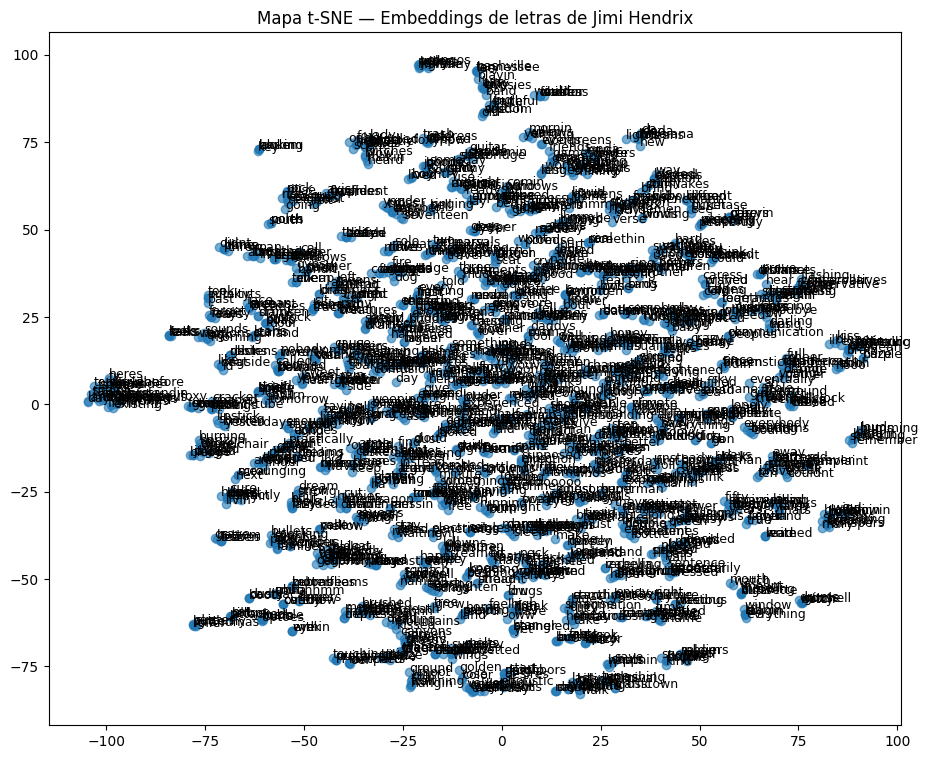

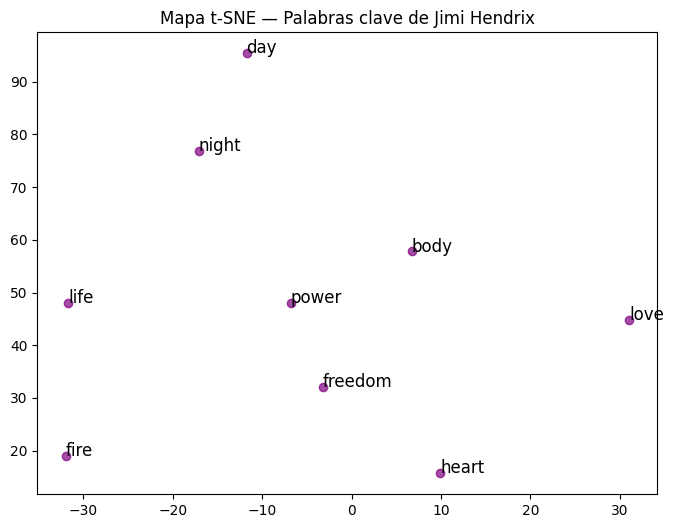

In [4]:
# ==============================================
# 4 - Visualizar agrupación de vectores
# ==============================================

import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
import random

X = modelo.wv[modelo.wv.key_to_index]
labels = list(modelo.wv.key_to_index.keys())

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
Y = tsne.fit_transform(X)

plt.figure(figsize=(11, 9))
plt.scatter(Y[:, 0], Y[:, 1], alpha=0.6)
for i, word in enumerate(labels):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), fontsize=9)

plt.title("Mapa t-SNE — Embeddings de letras de Jimi Hendrix")
plt.show()

# Verlo con zomm
palabras = random.sample(list(modelo.wv.key_to_index.keys()), 200)
X = modelo.wv[palabras]

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
Y = tsne.fit_transform(X)

fig = px.scatter(
    x=Y[:, 0],
    y=Y[:, 1],
    text=palabras,
    title="Mapa t-SNE interactivo — Embeddings de Hendrix"
)
fig.update_traces(textposition='top center')
fig.show()

# Solo las palabras del vocabulario que estan en targets
palabras = [w for w in targets if w in modelo.wv.key_to_index]
X = modelo.wv[palabras]

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
Y = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(Y[:, 0], Y[:, 1], color="purple", alpha=0.7)
for i, word in enumerate(palabras):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), fontsize=12)
plt.title("Mapa t-SNE — Palabras clave de Jimi Hendrix")
plt.show()


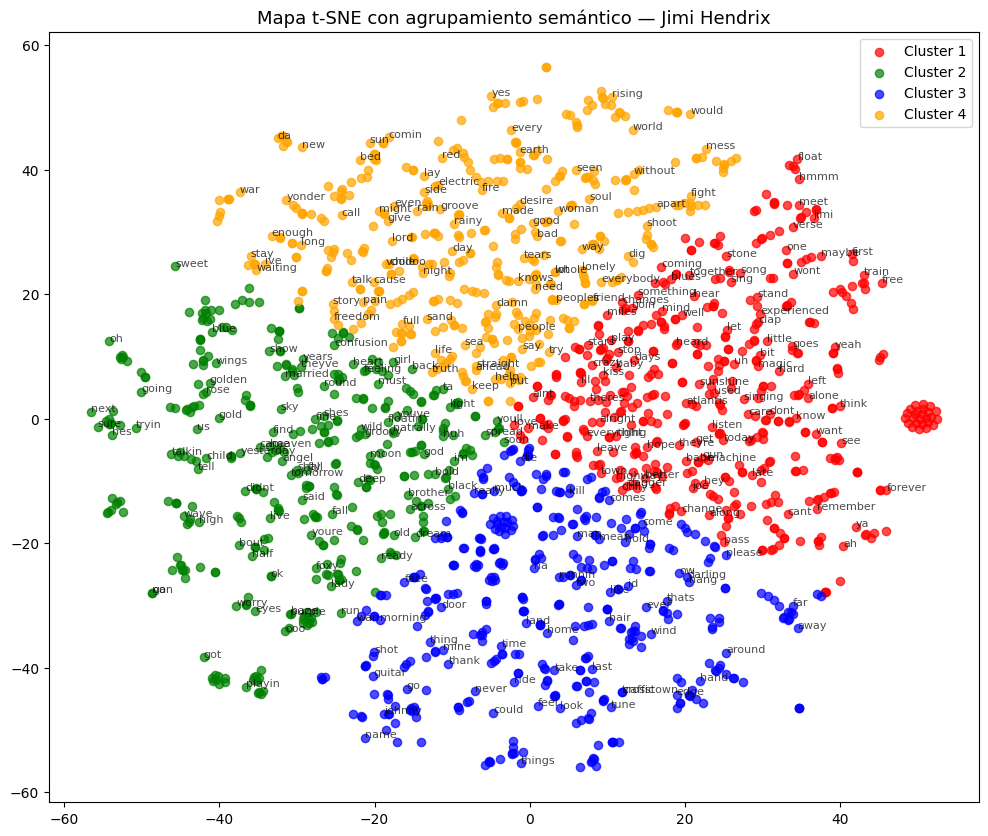


Cluster 1: yeah, baby, love, dont, well, know, see, hey, make, get, mind, let, right, hear, one ...

Cluster 2: got, im, na, oh, gon, back, said, floatin, live, youve, fly, sweet, going, round, us ...

Cluster 3: go, like, take, time, around, thats, come, man, away, look, feel, home, please, wan, thing ...

Cluster 4: lord, say, way, everybody, day, world, comin, long, cause, people, voodoo, bad, side, made, sea ...


In [5]:
# ======================================
# 5 - Agrupamiento semántico (K-Means)
# ======================================

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# === t-SNE dimensionality reduction ===
X = modelo.wv[modelo.wv.key_to_index]
labels = list(modelo.wv.key_to_index.keys())

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Y = tsne.fit_transform(X)

# === K-Means clustering usando las proyecciones reducidas ===
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(Y)

# === Visualización ===
plt.figure(figsize=(12, 10))
colors = ['red', 'green', 'blue', 'orange']

for c in range(n_clusters):
    plt.scatter(Y[clusters == c, 0], Y[clusters == c, 1],
                s=35, alpha=0.7, color=colors[c], label=f'Cluster {c+1}')

# Para evitar superposición, solo anotamos las primeras 300 palabras
for i, word in enumerate(labels[:300]):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), fontsize=8, alpha=0.7)

plt.title("Mapa t-SNE con agrupamiento semántico — Jimi Hendrix", fontsize=13)
plt.legend()
plt.show()

# === Palabras por clúster ===
cluster_words = {i: [] for i in range(n_clusters)}
for i, word in enumerate(labels):
    cluster_words[clusters[i]].append(word)

for k, v in cluster_words.items():
    print(f"\nCluster {k+1}: {', '.join(v[:15])} ...")




## Análisis y conclusiones — Embeddings personalizados con letras de Jimi Hendrix  
**Alumno:** Juan Manuel Calabia  
**Materia:** Procesamiento del Lenguaje Natural I – FIUBA  
**Tema:** Word Embeddings con Gensim sobre corpus musical  

---

### 1️⃣ Introducción  
El objetivo de este trabajo fue generar un modelo de *word embeddings* utilizando **Gensim**, aplicando conceptos de representación densa de palabras y el paradigma *Skip-Gram*.  
Se construyó un corpus a partir de **letras de canciones de Jimi Hendrix**.  

---

### 2️⃣ Metodología  
- **Preprocesamiento:** normalización del texto (minúsculas), eliminación de puntuación, tokenización y remoción de *stopwords*.  
- **Modelo:** `Word2Vec` con parámetros `vector_size=100`, `window=5`, `min_count=1`, `sg=1` (*Skip-Gram*) y `epochs=300`.  
- **Análisis:** se examinaron las palabras más cercanas a un conjunto de términos clave (`love`, `fire`, `freedom`, `power`, `life`, `day`, `night`, `heart`, `body`).  
- **Visualización:** reducción de dimensionalidad con **t-SNE** y agrupamiento semántico con **K-Means**.

---

### 3️⃣ Resultados  
Las palabras seleccionadas reflejan los ejes conceptuales más frecuentes en el universo poético de Hendrix:  

- **“love”** se asocia con emociones humanas, conexión espiritual y sensualidad.  
- **“freedom”** aparece junto a palabras relacionadas con la liberación y la búsqueda interior.  
- **“power”** agrupa términos vinculados a la energía, la mente y la transformación.  
- **“life”**, **“day”** y **“night”** se conectan con la temporalidad, la experiencia vital y los ciclos de la existencia.  
- **“heart”** y **“body”** aparecen como símbolos de humanidad y deseo, anclando el lenguaje místico en lo terrenal.  

El mapa t-SNE evidenció agrupamientos naturales: uno emocional (*love*, *heart*, *body*), otro existencial (*life*, *day*, *night*) y otro energético o conceptual (*freedom*, *power*).  

---

### 4️⃣ Conclusiones  
- El modelo logró capturar la esencia semántica de las letras de Hendrix, revelando tres núcleos temáticos claros: emocional, vital y espiritual.  
- Las palabras relacionadas con el cuerpo y las emociones forman un grupo cohesivo, mientras que los conceptos de libertad y poder se posicionan como vectores de trascendencia.  
- El modelo confirma que, incluso en un corpus artístico, los *embeddings* pueden reflejar la estructura simbólica del lenguaje poético.  

En suma, el espacio vectorial de Hendrix es una constelación de **amor, energía y conciencia**: las palabras laten como acordes, entre el cuerpo y el cosmos.   

